# Logistic Model Building

Set random_state to 42 in every portion of our model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, make_scorer,
    accuracy_score, roc_auc_score, recall_score, balanced_accuracy_score,
    precision_score, f1_score, RocCurveDisplay)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

In [2]:
df = pd.read_csv('../data/cleaning_data_phase2.csv.zip')

In [3]:
df.head()

,_michd,_sex,genhlth,physhlth,menthlth,addepev3,checkup1,_totinda,_rfhype6,cholmed3,...,_metstat,_imprace,_age80,_educag,ftjuda2_,frutda2_,grenda1_,frnchda_,potada1_,vegeda2_
0,No,Female,Poor,20.0,10.0,No,Within past 2 years (1 year but < 2 years ago),No physical activity or exercise in last 30 days,No,Yes,...,yes,white,70.0,highschool,5.397605e-79,100.0,5.700000e+01,4.300000e+01,14.0,100.0
1,Yes,Female,Good,0.0,0.0,No,Within past year (anytime < 12 months ago),Had physical activity or exercise,Yes,Yes,...,yes,black,67.0,graduated college,5.397605e-79,100.0,1.400000e+01,5.397605e-79,14.0,100.0
2,Yes,Female,Very good,0.0,0.0,No,Within past year (anytime < 12 months ago),No physical activity or exercise in last 30 days,Yes,No,...,yes,black,72.0,highschool,5.397605e-79,100.0,5.397605e-79,1.400000e+01,14.0,43.0
3,No,Female,Very good,0.0,10.0,No,Within past year (anytime < 12 months ago),Had physical activity or exercise,Yes,No,...,yes,white,62.0,highschool,7.100000e+01,43.0,1.000000e+01,5.700000e+01,27.0,71.0
4,Yes,Male,Poor,30.0,0.0,No,Within past year (anytime < 12 months ago),Had physical activity or exercise,No,Yes,...,no,other race,76.0,no highschool,5.397605e-79,100.0,1.000000e+02,2.900000e+01,29.0,100.0


### Baseline

In [4]:
df['_michd'].value_counts(normalize=True)

No     0.917841
Yes    0.082159
Name: _michd, dtype: float64

### The baseline of 0.917 suggests that our dataset is highly imbalanced.

In [5]:
df.isnull().sum()

_michd          0
_sex            0
genhlth         0
physhlth     8491
menthlth     7084
addepev3        0
checkup1        0
_totinda        0
_rfhype6        0
cholmed3        0
_rfchol3        0
cvdstrk3        0
_asthms1        0
chcscncr        0
chcocncr        0
chccopd3        0
chckdny2        0
diabete4        0
_drdxar3        0
marital         0
children     3684
_incomg1        0
employ1         0
htm4         9849
wtkg3       25486
_bmi5       30786
decide          0
diffwalk        0
diffdres        0
_state          0
_smoker3        0
usenow3         0
ecignow1        0
_drnkwk1    15125
_metstat        0
_imprace        0
_age80          0
_educag         0
ftjuda2_    24072
frutda2_    23649
grenda1_    23943
frnchda_    24471
potada1_    28095
vegeda2_    28150
dtype: int64

### Create Evaluation Function

In [76]:
# Create evaluation function
def evaluation(X_test, y_test, preds, model):
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    
    b_acc = balanced_accuracy_score(y_test, preds)
    recall = recall_score(y_test, preds, pos_label = "Yes")
    prec = precision_score(y_test, preds, pos_label = "Yes")
    f1 = f1_score(y_test, preds, pos_label = "Yes")

    print(f'balanced_accuracy: {b_acc}')
    print(f'recall: {recall}')
    print(f'precision: {prec}')
    print(f'f1 score: {f1}')

    return {
        'balanced_accuracy': b_acc,
        'recall': recall,
        'precision': prec,
        'f1_score': f1
    }

In [77]:
scores = []

### Create X and y

In [6]:
X = df.drop(columns = ['_michd', '_state'])
y = df['_michd']

### Split training and testing dataset

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42)

### Preprocess numerical and categorical variables seperately

In [8]:
df_num = X.select_dtypes(include=['float', 'int'])
df_cat = X.select_dtypes(include = ['O'])

In [9]:
df_num.shape, df_cat.shape, df.shape

((414511, 14), (414511, 28), (414511, 44))

### Handle the missing values in numerical columns by imputing them with the median, and then apply standard scaling.

In [10]:
num_transform = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', StandardScaler())
])

### Transform categorical columns using One-hot encoding and then apply standard scaling

In [11]:
cat_transform = Pipeline(steps = [
    ('onehot', OneHotEncoder(handle_unknown = 'ignore')),
    ('scaler', StandardScaler(with_mean = False, with_std = False))
])

In [12]:
preprocessor = ColumnTransformer(transformers = [
    ('num', num_transform, df_num.columns),
    ('cat', cat_transform, df_cat.columns)
])

### Build simple logistic regression model pipeline 

In [13]:
pipe = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(random_state=42))
])

In [14]:
pipe.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('scaler', StandardScaler())]),
                                    Index(['physhlth', 'menthlth', 'children', 'htm4', 'wtkg3', '_bmi5',
          '_drnkwk1', '_age80', 'ftjuda2_', 'frutda2_', 'grenda1_', 'frnchda_',
          'potada1_', 'vegeda2_'],
         dtype='object')),
                                   ('cat',
                                    Pipeline(steps=[('onehot',
                                                     OneHotEncoder(handle...
                                                     StandardScaler(with_mean=False,
                                                                    with_std=False))]),
                                    Index(['_sex', 'genhlth', 'addepev3',

In [15]:
lg_params = {
    'model__penalty': ['l2'],
    'model__max_iter': [1000]
}

In [16]:
gs_lg = GridSearchCV(pipe, param_grid=lg_params, cv = 3)

In [17]:
gs_lg.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['physhlth', 'menthlth', 'children', 'htm4', 'wtkg3', '_bmi5',
       '_drnkwk1', '_age80', 'ftjuda2_', 'frutda2_', 'grenda1_', 'frnchda_',
       'potada1_', 'vegeda2_'],
      dtype='obj...
       'cholmed3', '_rfchol3', 'cvdstrk3', '_asthms1', 'chcscncr', 'chcocncr',
       'chccopd3', 'chckdny2', 'diabete4', '_drdxar3', 'ma

In [18]:
y_pred = gs_lg.predict(X_test)

balanced_accuracy: 0.5596616503354611
recall: 0.12966878083157152
precision: 0.5287356321839081
f1 score: 0.2082625919637804


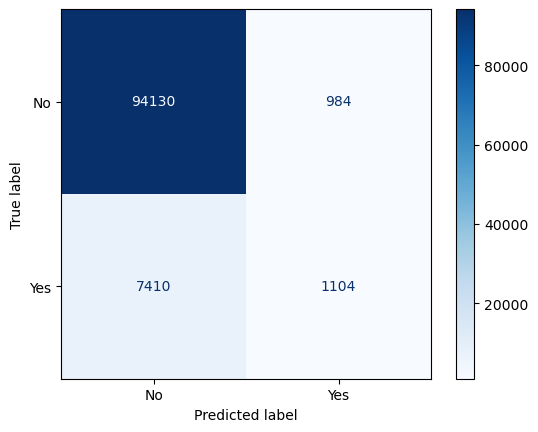

In [78]:
scores.append(evaluation(X_test, y_test, gs_lg.predict(X_test), gs_lg))

Using a simple logistic regression model and accuracy as the metric resulted in lower balanced accuracy and poor recall.

### Oversample the minority class

In [24]:
# Oversample the minority class
pipe_oversample = ImbPipeline(steps = [
    ('preprocessor', preprocessor),
    ('sampling', RandomOverSampler(random_state=42)),
    ('model', LogisticRegression(random_state=42))
])

In [25]:
pipe_oversample.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('scaler', StandardScaler())]),
                                    Index(['physhlth', 'menthlth', 'children', 'htm4', 'wtkg3', '_bmi5',
          '_drnkwk1', '_age80', 'ftjuda2_', 'frutda2_', 'grenda1_', 'frnchda_',
          'potada1_', 'vegeda2_'],
         dtype='object')),
                                   ('cat',
                                    Pipeline(steps=[('onehot',
                                                     OneHotEncoder(handle...
                                                     StandardScaler(with_mean=False,
                                                                    with_std=False))]),
                                    Index(['_sex', 'genhlth', 'addepev3',

In [26]:
lg_oversample_params = {
    'sampling__sampling_strategy': [.25, .75],
    'model__max_iter': [1000]
}

In [27]:
gs_lg_oversample = GridSearchCV(pipe_oversample, param_grid=lg_oversample_params, cv = 3)

In [28]:
gs_lg_oversample.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['physhlth', 'menthlth', 'children', 'htm4', 'wtkg3', '_bmi5',
       '_drnkwk1', '_age80', 'ftjuda2_', 'frutda2_', 'grenda1_', 'frnchda_',
       'potada1_', 'vegeda2_'],
      dtype='obj...
       'chccopd3', 'chckdny2', 'diabete4', '_drdxar3', 'marital', '_incomg1',
       'employ1', 'decide', 'diffwalk', 'diffdres', '_smoke

balanced_accuracy: 0.6714836080461467
recall: 0.40204369274136714
precision: 0.3785666887856669
f1 score: 0.3899521531100479


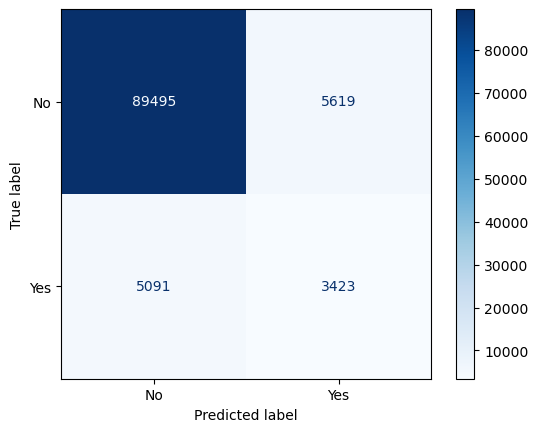

In [79]:
scores.append(evaluation(X_test, y_test, gs_lg_oversample.predict(X_test), gs_lg_oversample))

Once I implemented oversampling on the minority class, there was an improvement in balanced accuracy. However, the recall value remained low.

In [30]:
# Change the scoring metric to balanced-accuracy
gs_lg_oversample_bcc = GridSearchCV(pipe_oversample, param_grid=lg_oversample_params, cv = 3, scoring='balanced_accuracy')
gs_lg_oversample_bcc.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['physhlth', 'menthlth', 'children', 'htm4', 'wtkg3', '_bmi5',
       '_drnkwk1', '_age80', 'ftjuda2_', 'frutda2_', 'grenda1_', 'frnchda_',
       'potada1_', 'vegeda2_'],
      dtype='obj...
       'chccopd3', 'chckdny2', 'diabete4', '_drdxar3', 'marital', '_incomg1',
       'employ1', 'decide', 'diffwalk', 'diffdres', '_smoke

balanced_accuracy: 0.7763814192105138
recall: 0.7475922010805732
precision: 0.25566356041131105
f1 score: 0.38102364561508534


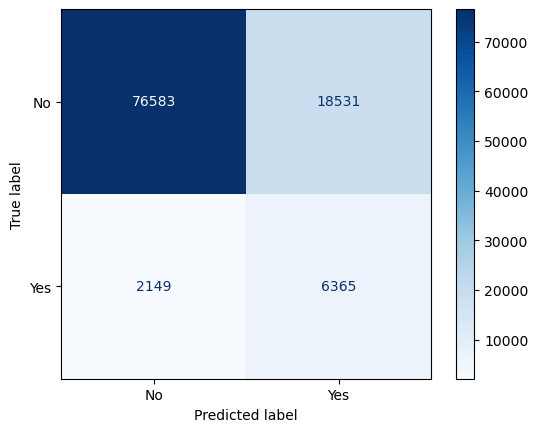

In [80]:
scores.append(evaluation(X_test, y_test, gs_lg_oversample_bcc.predict(X_test), gs_lg_oversample_bcc))

Compare to previous models, Once I adjusted the metric to balanced accuracy, the recall saw a significant increase.

### SMOTE

In [32]:
pipe_smote = ImbPipeline(steps = [
    ('preprocessor', preprocessor),
    ('sampling', SMOTE(random_state = 42)),
    ('model', LogisticRegression(random_state=42))
])

In [33]:
lg_smote_params = {
    'model__max_iter': [1000]
}

In [34]:
gs_lg_smote = GridSearchCV(pipe_smote, param_grid=lg_smote_params, cv = 3, scoring='balanced_accuracy')
gs_lg_smote.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['physhlth', 'menthlth', 'children', 'htm4', 'wtkg3', '_bmi5',
       '_drnkwk1', '_age80', 'ftjuda2_', 'frutda2_', 'grenda1_', 'frnchda_',
       'potada1_', 'vegeda2_'],
      dtype='obj...
       'cholmed3', '_rfchol3', 'cvdstrk3', '_asthms1', 'chcscncr', 'chcocncr',
       'chccopd3', 'chckdny2', 'diabete4', '_drdxar3', 'ma

balanced_accuracy: 0.7786508457941417
recall: 0.7973925299506694
precision: 0.2291645569620253
f1 score: 0.35601352945803505


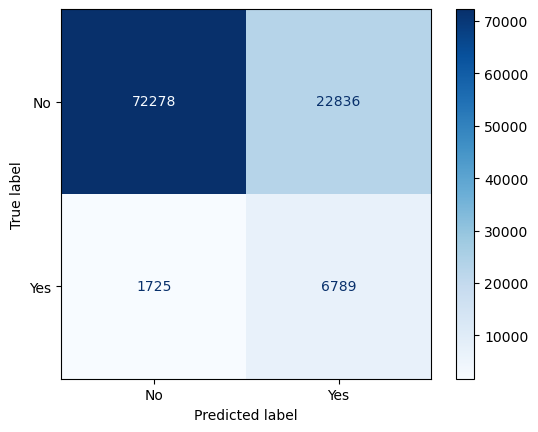

In [81]:
scores.append(evaluation(X_test, y_test, gs_lg_smote.predict(X_test), gs_lg_smote))

Compare to previous models, Employing the SMOTE sampling method resulted in an enhanced recall, without compromising the balanced accuracy.

### ADASYN

In [36]:
pipe_adasyn = ImbPipeline(steps = [
    ('preprocessor', preprocessor),
    ('sampling', ADASYN(random_state = 42)),
    ('model', LogisticRegression(random_state=42))
])

In [37]:
lg_adasyn_params = {
    'model__max_iter': [1000]
}

In [38]:
gs_lg_adasyn = GridSearchCV(pipe_adasyn, param_grid=lg_adasyn_params, cv = 3, scoring='balanced_accuracy')
gs_lg_adasyn.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['physhlth', 'menthlth', 'children', 'htm4', 'wtkg3', '_bmi5',
       '_drnkwk1', '_age80', 'ftjuda2_', 'frutda2_', 'grenda1_', 'frnchda_',
       'potada1_', 'vegeda2_'],
      dtype='obj...
       'cholmed3', '_rfchol3', 'cvdstrk3', '_asthms1', 'chcscncr', 'chcocncr',
       'chccopd3', 'chckdny2', 'diabete4', '_drdxar3', 'ma

balanced_accuracy: 0.7786936896746863
recall: 0.8132487667371389
precision: 0.2214971209213052
f1 score: 0.34816714436566604


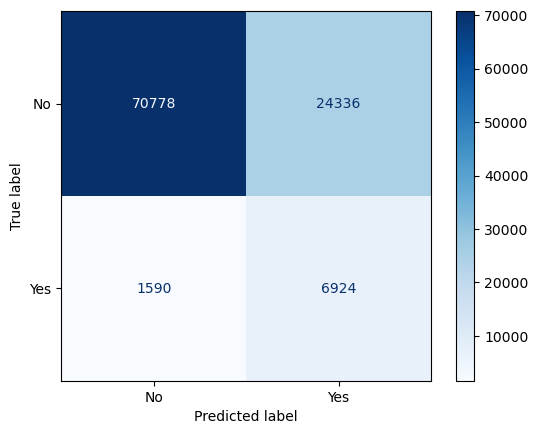

In [82]:
scores.append(evaluation(X_test, y_test, gs_lg_adasyn.predict(X_test), gs_lg_adasyn))

Compare to previous models, Employing the ADASYN sampling method resulted in an enhanced recall, without compromising the balanced accuracy.

### OverWeight

In [40]:
pipe_weight = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(class_weight='balanced', random_state=42))
])

In [41]:
pipe_weight.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('scaler', StandardScaler())]),
                                    Index(['physhlth', 'menthlth', 'children', 'htm4', 'wtkg3', '_bmi5',
          '_drnkwk1', '_age80', 'ftjuda2_', 'frutda2_', 'grenda1_', 'frnchda_',
          'potada1_', 'vegeda2_'],
         dtype='object')),
                                   ('cat',
                                    Pipeline(steps=[('onehot',
                                                     OneHotEncoder(handle...
                                                     StandardScaler(with_mean=False,
                                                                    with_std=False))]),
                                    Index(['_sex', 'genhlth', 'addepev3',

In [42]:
lg_weight_params = {
    'model__max_iter': [1000]
}

In [43]:
gs_lg_weight = GridSearchCV(pipe_weight, param_grid=lg_weight_params, cv = 3, scoring='balanced_accuracy')
gs_lg_weight.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['physhlth', 'menthlth', 'children', 'htm4', 'wtkg3', '_bmi5',
       '_drnkwk1', '_age80', 'ftjuda2_', 'frutda2_', 'grenda1_', 'frnchda_',
       'potada1_', 'vegeda2_'],
      dtype='obj...
       'cholmed3', '_rfchol3', 'cvdstrk3', '_asthms1', 'chcscncr', 'chcocncr',
       'chccopd3', 'chckdny2', 'diabete4', '_drdxar3', 'ma

balanced_accuracy: 0.7847271959775144
recall: 0.8110171482264505
precision: 0.23108329707841102
f1 score: 0.35968225029300693


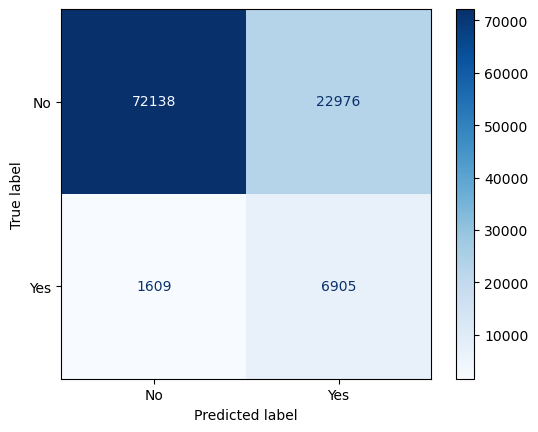

In [83]:
scores.append(evaluation(X_test, y_test, gs_lg_weight.predict(X_test), gs_lg_weight))

After applying the overweight method, there's a slight increase in balanced accuracy and a small decrease in recall when compared to ADASYN. However, given that overweight is computationally much quicker than ADASYN, the Logistic Regression model with overweight will be my preferred choice.

### Hyper tuning with Overweight Method

As Overweight runs fast and has the best result, we will hyptertune paramters on this one

In [58]:
pipe_tune = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(class_weight='balanced', random_state=42))
])

In [60]:
pipe_tune.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('num',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('scaler', StandardScaler())]),
                                    Index(['physhlth', 'menthlth', 'children', 'htm4', 'wtkg3', '_bmi5',
          '_drnkwk1', '_age80', 'ftjuda2_', 'frutda2_', 'grenda1_', 'frnchda_',
          'potada1_', 'vegeda2_'],
         dtype='object')),
                                   ('cat',
                                    Pipeline(steps=[('onehot',
                                                     OneHotEncoder(handle...
                                                     StandardScaler(with_mean=False,
                                                                    with_std=False))]),
                                    Index(['_sex', 'genhlth', 'addepev3',

In [70]:
tune_params = {
    'model__max_iter': [1000, 2000],
    'model__penalty': ['none', 'l1', 'l2', 'elasticnet'],
    'model__solver': ['lbfgs', 'saga'], 
    'model__C': [1, 10, 100, 1000]
}

In [71]:
gs_tune = GridSearchCV(pipe_tune, param_grid=tune_params, cv = 3, scoring='balanced_accuracy')
gs_tune.fit(X_train, y_train)

/Users/ranma/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ranma/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ranma/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ranma/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ranma/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ranma/opt/anaconda3/lib/python3.9/site-pack

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['physhlth', 'menthlth', 'children', 'htm4', 'wtkg3', '_bmi5',
       '_drnkwk1', '_age80', 'ftjuda2_', 'frutda2_', 'grenda1_', 'frnchda_',
       'potada1_', 'vegeda2_'],
      dtype='obj...
       'employ1', 'decide', 'diffwalk', 'diffdres', '_smoker3', 'usenow3',
       'ecignow1', '_metstat', '_imprace', '_educag'],
      d

In [72]:
gs_tune.best_params_

{'model__C': 1,
 'model__max_iter': 1000,
 'model__penalty': 'none',
 'model__solver': 'saga'}

balanced_accuracy: 0.7846684691746015
recall: 0.8108996946206248
precision: 0.23105756358768406
f1 score: 0.35963952700942853


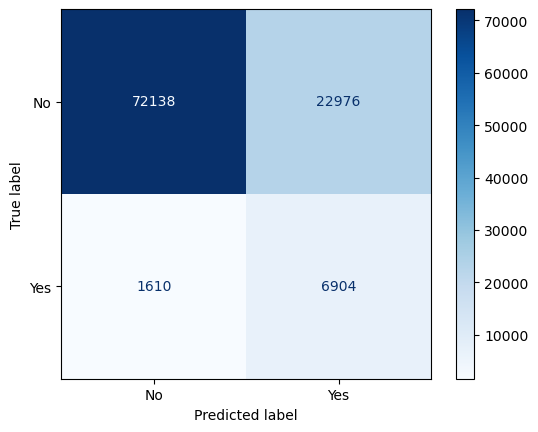

In [84]:
scores.append(evaluation(X_test, y_test, gs_tune.predict(X_test), gs_tune))

After hyptertune, the recall and balanced accuracy do not improve.

# Compare the results

In [85]:
scores

[{'balanced_accuracy': 0.5596616503354611,
  'recall': 0.12966878083157152,
  'precision': 0.5287356321839081,
  'f1_score': 0.2082625919637804},
 {'balanced_accuracy': 0.6714836080461467,
  'recall': 0.40204369274136714,
  'precision': 0.3785666887856669,
  'f1_score': 0.3899521531100479},
 {'balanced_accuracy': 0.7763814192105138,
  'recall': 0.7475922010805732,
  'precision': 0.25566356041131105,
  'f1_score': 0.38102364561508534},
 {'balanced_accuracy': 0.7786508457941417,
  'recall': 0.7973925299506694,
  'precision': 0.2291645569620253,
  'f1_score': 0.35601352945803505},
 {'balanced_accuracy': 0.7786936896746863,
  'recall': 0.8132487667371389,
  'precision': 0.2214971209213052,
  'f1_score': 0.34816714436566604},
 {'balanced_accuracy': 0.7847271959775144,
  'recall': 0.8110171482264505,
  'precision': 0.23108329707841102,
  'f1_score': 0.35968225029300693},
 {'balanced_accuracy': 0.7846684691746015,
  'recall': 0.8108996946206248,
  'precision': 0.23105756358768406,
  'f1_score

In [89]:
evaluations = pd.DataFrame(scores, index = ['lgr', 'lgr_oversample', 'lgr_oversample_bac', 'lgr_smote_bac', 'lgr_adasyn_bac', 'lgr_weight_bac', 'lgr_weight_tune_bac'])

evaluations

evaluations.to_csv('../data/scores_LogisticRegression.csv')

After evaluating various sampling methods for logistic regression, the ADASYN method stands out with the highest recall and a reasonable balanced accuracy.

### Use Logistic Regression with ADASYN to analyze

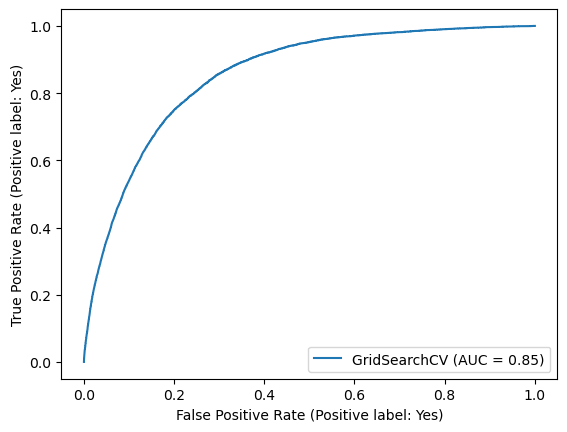

In [48]:
RocCurveDisplay.from_estimator(gs_lg_adasyn, X_test, y_test);

The Roc curve is not bad as the it is not far away the top left corner.

### Find coefficient

In [49]:
lg_num = gs_lg_adasyn.best_estimator_['preprocessor'].transformers_[0][2]

In [50]:
lg_cat = gs_lg_adasyn.best_estimator_['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(input_features=df_cat.columns)

In [51]:
feature_names = np.concatenate([lg_num, lg_cat])

In [52]:
coef_features = pd.DataFrame(gs_lg_adasyn.best_estimator_.named_steps['model'].coef_[0],
                             index = feature_names, 
                             columns = ['coefficient'])

In [53]:
coef_features

,coefficient
physhlth,0.001950
menthlth,0.046507
children,0.018230
htm4,0.019069
wtkg3,-0.110322
...,...
_educag_attended college,0.036788
_educag_graduated college,-0.057047
_educag_highschool,-0.016531
_educag_missing,-0.126394


### Top Five Coefficient

In [54]:
features_top_coef = coef_features.sort_values('coefficient', ascending = False)[: 5]

features_top_coef

,coefficient
genhlth_Poor,0.784153
_age80,0.682038
cholmed3_Yes,0.669721
usenow3_not sure,0.501643
cvdstrk3_Yes,0.439639


### Bottom Five Coefficient

In [55]:
features_bot_coef = coef_features.sort_values('coefficient')[: 5]

features_bot_coef

,coefficient
genhlth_Excellent,-1.043458
diffwalk_refused,-0.585811
genhlth_Very good,-0.548534
cholmed3_Refused,-0.540574
cvdstrk3_No,-0.505347


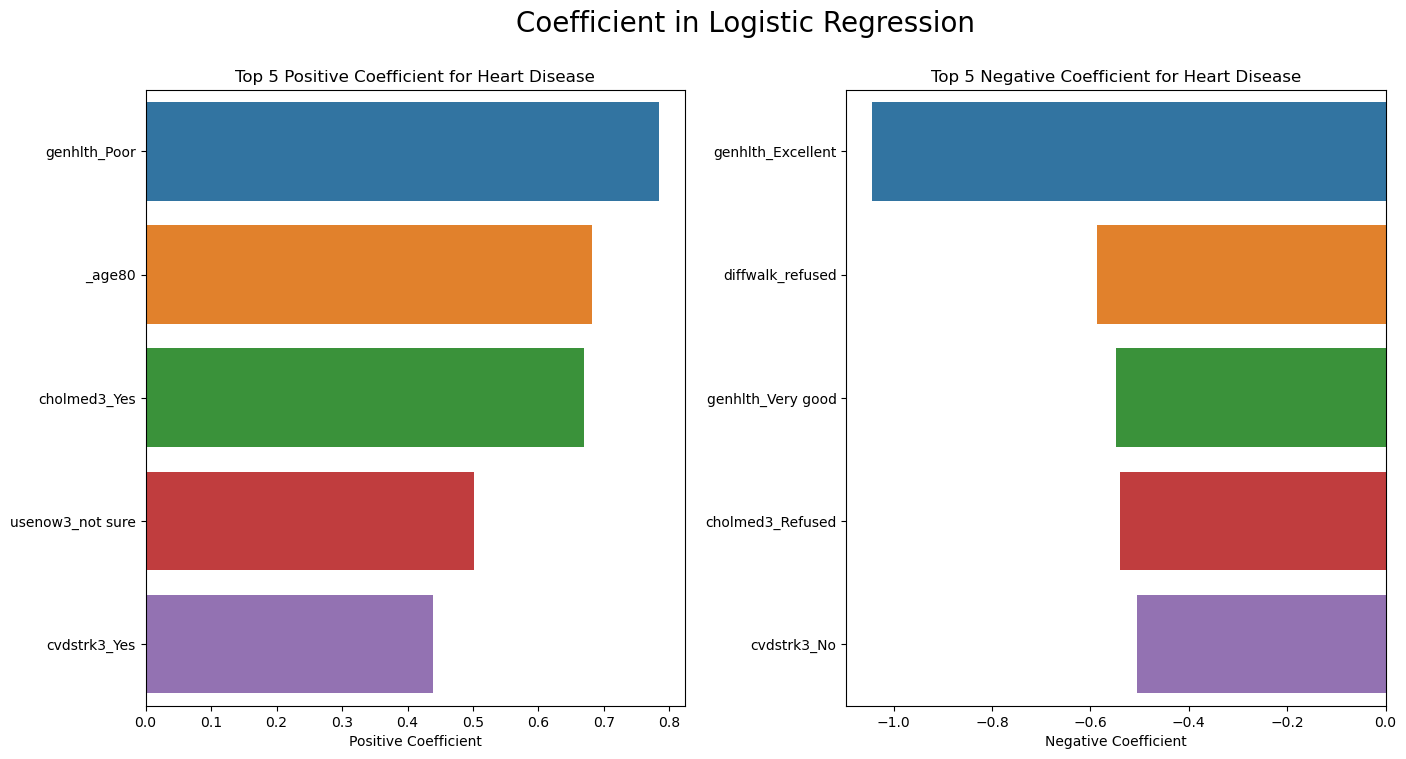

In [90]:
fig, ax = plt.subplots(1, 2, figsize = (16, 8))
plt.subplots_adjust(wspace=0.3)

sns.barplot(x = features_top_coef.coefficient, y = features_top_coef.index, ax = ax[0])
sns.barplot(x = features_bot_coef.coefficient, y = features_bot_coef.index, ax = ax[1])

ax[0].set(title = 'Top 5 Positive Coefficient for Heart Disease', xlabel = 'Positive Coefficient')
ax[1].set(title = 'Top 5 Negative Coefficient for Heart Disease', xlabel = 'Negative Coefficient')

fig.suptitle('Coefficient in Logistic Regression', fontsize = 20)

plt.savefig('../graph/logistic_coefficient.png');

On the left barchart, we have the top 5 positive coefficents for the heart disease. These include important terms like poor general health, age over 80, takeing medicine for your cholesterol and had a stroke before. The higher the coefficient, the more likely the person will have a heart disease. On the right barchart, we have the top negtive coefficients for the heart disease. These terms include excellent/good health and not have stroke. The more negative the coefficient, the less probability the person will have a heart disease.